#Rafael Souza de Barros
## Objetivo e perguntas do projeto MVP - Engenharia de dados
### Pós-graduação em ciência de dados e _analytics_ - PUC-RIO


O presente projeto foi elaborado para fins de conclusão de módulo (_sprint_) de engenhraria de dados do curso de pós-graduação em ciência de dados e _analytics_ da PUC-RIO e tem como objetivo consumir dados disponibilizados de forma pública e aberta pelo Supremo Tribunal Federal - STF, por meio do site "Corte Aberta", disponível em (https://portal.stf.jus.br/hotsites/corteaberta/).

O objetivo é criar um banco de dados que sirva para analisar a tramitação dos processos no STF, suas principais características e resultados, o que pode auxiliar diversas instituições públicas e privadas na gestão de demandas, especialmente as repetitivas, explicitando os custos e a eficiência da judicialização massificada dos mais diversos temas.

Decidi utilizar nesse projeto os conjuntos de dados sobre distribuições e registros e sobre decisões (monocráticas ou colegiadas), filtrados para o ano de 2025, por uma questão de limitação de recursos. 

Com esses dados, objetiva-se identificar possíveis tendências de julgamentos da Suprema Corte em função dos temas, do Tribunal de origem e das partes, respondendo as seguintes perguntas:

1. Quais e quantos processos foram autuados no ano de 2025?
2. É possível identificar as pessoas e entidades com maior quantidade de recursos e o polo processual que elas ocupam?
3. Qual o resultado dos julgamentos desses processos? 
4. Existe alguma tendência nos julgamentos (favoráveis ou desfavoráveis) por tema, origem ou pessoa/entidade?
5. Qual tempo médio de tramitação dos recursos por origem e por Ministro Relator dos processos?

Para alcançar a resposta dessas perguntas serão seguidas as seguintes etapas:

1. Carregar no _Databricks_ as tabelas obtidas no site (https://portal.stf.jus.br/hotsites/corteaberta/)
2. Manipular/limpar os dados (definir tipos de dados nas tabelas, juntar colunas Classe e Nº Processo, fazer join das 2 tabelas, etc.)
3. Construir catálogo de dados das tabelas ingeridas e limpas
4. Avaliar a qualidade dos dados e definir se há problemas que impeçam a resposta das perguntas iniciais
5. Analisar os dados e responder as perguntas propostas
6. Auto avaliação 




#### 1. Carregamento no _Databricks_ das tabelas obtidas no site (https://portal.stf.jus.br/hotsites/corteaberta/) - camada Bronze

In [0]:

# Carregando as funções

from pyspark.sql.functions import col, to_date, when, trim, regexp_replace, coalesce, lit, concat_ws, sum, count
from pyspark.sql.types import StringType
from pyspark.sql import DataFrame


# 1. Ler a tabelas carregadas no catálogo

dist_raw = spark.table("distribuicoes_2025_stf")

dec_raw = spark.table("decisoes_2025_stf")

 


In [0]:
dist_raw.printSchema()

root
 |-- Tipo de andamento: string (nullable = true)
 |-- Classe: string (nullable = true)
 |-- Nº do processo: long (nullable = true)
 |-- Link: string (nullable = true)
 |-- Ministro(a): string (nullable = true)
 |-- Última localização: string (nullable = true)
 |-- Data da autuação: date (nullable = true)
 |-- Data da baixa: string (nullable = true)
 |-- Em tramitação: string (nullable = true)
 |-- Grupo origem: string (nullable = true)
 |-- Meio processo: string (nullable = true)
 |-- Data do andamento: date (nullable = true)
 |-- Andamento: string (nullable = true)
 |-- Subgrupo do andamento: string (nullable = true)
 |-- Indicador de substituição ou redistribuição: string (nullable = true)
 |-- Orgão origem: string (nullable = true)
 |-- Procedência: string (nullable = true)
 |-- Ramo do direito: string (nullable = true)
 |-- Assunto completo: string (nullable = true)
 |-- Polo ativo: string (nullable = true)
 |-- Advogado polo ativo: string (nullable = true)
 |-- Polo passivo: 

In [0]:
dec_raw.printSchema()

root
 |-- idFatoDecisao: long (nullable = true)
 |-- Processo: string (nullable = true)
 |-- Relator atual: string (nullable = true)
 |-- Meio Processo: string (nullable = true)
 |-- Origem decisão: string (nullable = true)
 |-- Ambiente julgamento: string (nullable = true)
 |-- Data de autuação: string (nullable = true)
 |-- Data baixa: string (nullable = true)
 |-- Indicador colegiado: string (nullable = true)
 |-- Ano da decisão: long (nullable = true)
 |-- Data da decisão: string (nullable = true)
 |-- Tipo decisão: string (nullable = true)
 |-- Andamento decisão: string (nullable = true)
 |-- Observação do andamento: string (nullable = true)
 |-- Ramo direito: string (nullable = true)
 |-- Assuntos do processo: string (nullable = true)
 |-- Indicador de tramitação: string (nullable = true)
 |-- Órgão julgador: string (nullable = true)



#### 2. Manipular/limpar os dados (definir tipos de dados nas tabelas, juntar colunas Classe e Nº Processo, fazer join das 2 tabelas, etc.) - camada Prata

##### 2.1 Ajustando tipos de dados das colunas

Identificou-se pelas tabelas acima, que os dados ingeridos não tiveram os tipos de dados corretamente classificados, como as colunas "Data de Autuação" e "Data Baixa" que foram consideradas como _string_.

Assim, foi necessário identificar manualmente esses tipos. Além disso, algumas colunas de datas vieram no formato data/hora e outras apenas no formata data (dd/mm/yyyy), sendo necessária a manipulação para utilização desses dados.

In [0]:


dist_typed = (
    dist_raw
    .withColumn("Nº do processo", col("Nº do processo").cast("long"))
    .withColumn(
        "Data da autuação",
        when(trim(col("Data da autuação")) == "-", None)
        .otherwise(to_date(col("Data da autuação"), "dd/MM/yyyy"))
    )
    .withColumn(
        "Data da baixa",
        when(trim(col("Data da baixa")) == "-", None)
        .otherwise(to_date(col("Data da baixa"), "dd/MM/yyyy"))
    )
    .withColumn(
        "Data do andamento",
        when(trim(col("Data do andamento")) == "-", None)
        .otherwise(to_date(col("Data do andamento"), "dd/MM/yyyy"))
    )
    .withColumn(
        "Em tramitação",
        when(trim(col("Em tramitação")) == "Sim", True)
        .when(trim(col("Em tramitação")) == "Não", False)
        .otherwise(None)
        .cast("boolean")
    )
    .withColumn(
        "Indicador de substituição ou redistribuição",
        when(trim(col("Indicador de substituição ou redistribuição")) == "Sim", True)
        .when(trim(col("Indicador de substituição ou redistribuição")) == "Não", False)
        .otherwise(None)
        .cast("boolean")
    )
    .withColumn(
    "processo",
    concat_ws(" ", col("Classe"), col("Nº do processo"))
)
)



def normaliza_data(c):
    return when(trim(col(c)).isin("*NI*", "-", ""), lit(None)) \
        .otherwise(
            to_date(
                regexp_replace(col(c), r"\s.*", ""),
                "dd/MM/yyyy"
            )
        )

dec_typed = (
    dec_raw
    .withColumn("idFatoDecisao", col("idFatoDecisao").cast("long"))
    .withColumn("Ano da decisão", col("Ano da decisão").cast("int"))
    .withColumn("Data de autuação", normaliza_data("Data de autuação"))
    .withColumn("Data baixa", normaliza_data("Data baixa"))
    .withColumn("Data da decisão", normaliza_data("Data da decisão"))
    .withColumn(
        "Indicador de tramitação",
        when(trim(col("Indicador de tramitação")) == "Sim", True)
        .when(trim(col("Indicador de tramitação")) == "Não", False)
        .otherwise(None)
        .cast("boolean")
    )
)

##### 2.2 Renomeando colunas e salvando em formato Delta na camada _Silver_

Para salvar os conjuntos de dados em formato Delta, foi constatado que os nomes das colunas não eram suportados por esse formato, tendo sido preciso a alteração dos nomes para formas compatíveis.

Também se identiicou que alguns valores inexistentes estavam preenchidos com símbolos, o que dificulta a sua contagem como nulos, tendo sido feita, então, a explicitação desses valores nulos, para fins de avaliação da qualidade dos dados.

Por fim, foi criada a base de dados "silver" e salvos os dados limpos em formato Delta.

In [0]:


# Renomear colunas para nomes válidos em Delta

dec = dec_typed

rename_map_dec = {
    "idFatoDecisao": "id_fato_decisao",
    "Processo": "processo",
    "Relator atual": "relator_atual",
    "Meio Processo": "meio_processo",
    "Origem decisão": "origem_decisao",
    "Ambiente julgamento": "ambiente_julgamento",
    "Data de autuação": "data_autuacao",
    "Data baixa": "data_baixa",
    "Indicador colegiado": "indicador_colegiado",
    "Ano da decisão": "ano_decisao",
    "Data da decisão": "data_decisao",
    "Tipo decisão": "tipo_decisao",
    "Andamento decisão": "andamento_decisao",
    "Observação do andamento": "observacao_andamento",
    "Ramo direito": "ramo_direito",
    "Assuntos do processo": "assuntos_processo",
    "Indicador de tramitação": "indicador_tramitacao",
    "Órgão julgador": "orgao_julgador",
}

for old, new in rename_map_dec.items():
    dec = dec.withColumnRenamed(old, new)



dist = dist_typed

rename_map_dist = {
    "Tipo de andamento": "tipo_andamento",
    "Classe": "classe",
    "Nº do processo": "num_processo",
    "Link": "link",
    "Ministro(a)": "ministro",
    "Última localização": "ultima_localizacao",
    "Data da autuação": "data_autuacao",
    "Data da baixa": "data_baixa",
    "Em tramitação": "em_tramitacao",
    "Grupo origem": "grupo_origem",
    "Meio processo": "meio_processo",
    "Data do andamento": "data_andamento",
    "Andamento": "andamento",
    "Subgrupo do andamento": "subgrupo_andamento",
    "Indicador de substituição ou redistribuição": "ind_substituicao_redistribuicao",
    "Orgão origem": "orgao_origem",
    "Procedência": "procedencia",
    "Ramo do direito": "ramo_direito",
    "Assunto completo": "assunto_completo",
    "Polo ativo": "polo_ativo",
    "Advogado polo ativo": "advogado_polo_ativo",
    "Polo passivo": "polo_passivo",
    "Advogado polo passivo": "advogado_polo_passivo",
    "processo": "processo"
}

for old, new in rename_map_dist.items():
    dist = dist.withColumnRenamed(old, new)


# Explicitando valores nulos para as linhas preenchidas com "-", "", "*NI*", "N/I", "NA"

dist_corrigido = dist

for campo in dist.schema.fields:
    if isinstance(campo.dataType, StringType):
        dist_corrigido = dist_corrigido.withColumn(
            campo.name,
            when(trim(col(campo.name)).isin("-", "", "*NI*", "N/I", "NA"), None)
            .otherwise(col(campo.name))
        )

dec_corrigido = dec

for campo in dec.schema.fields:
    if isinstance(campo.dataType, StringType):
        dec_corrigido = dec_corrigido.withColumn(
            campo.name,
            when(trim(col(campo.name)).isin("-", "", "*NI*", "N/I", "NA"), None)
            .otherwise(col(campo.name))
        )

# Gravando Silver em Delta

spark.sql("CREATE DATABASE IF NOT EXISTS silver")


dec_corrigido.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("silver.decisoes2025stf")


dist_corrigido.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("silver.distribuicoes2025stf")    




In [0]:
dist = spark.table("silver.distribuicoes2025stf")

dist.printSchema()

root
 |-- tipo_andamento: string (nullable = true)
 |-- classe: string (nullable = true)
 |-- num_processo: long (nullable = true)
 |-- link: string (nullable = true)
 |-- ministro: string (nullable = true)
 |-- ultima_localizacao: string (nullable = true)
 |-- data_autuacao: date (nullable = true)
 |-- data_baixa: date (nullable = true)
 |-- em_tramitacao: boolean (nullable = true)
 |-- grupo_origem: string (nullable = true)
 |-- meio_processo: string (nullable = true)
 |-- data_andamento: date (nullable = true)
 |-- andamento: string (nullable = true)
 |-- subgrupo_andamento: string (nullable = true)
 |-- ind_substituicao_redistribuicao: boolean (nullable = true)
 |-- orgao_origem: string (nullable = true)
 |-- procedencia: string (nullable = true)
 |-- ramo_direito: string (nullable = true)
 |-- assunto_completo: string (nullable = true)
 |-- polo_ativo: string (nullable = true)
 |-- advogado_polo_ativo: string (nullable = true)
 |-- polo_passivo: string (nullable = true)
 |-- advog

In [0]:
dec = spark.table("silver.decisoes2025stf")

dec.printSchema()

root
 |-- id_fato_decisao: long (nullable = true)
 |-- processo: string (nullable = true)
 |-- relator_atual: string (nullable = true)
 |-- meio_processo: string (nullable = true)
 |-- origem_decisao: string (nullable = true)
 |-- ambiente_julgamento: string (nullable = true)
 |-- data_autuacao: date (nullable = true)
 |-- data_baixa: date (nullable = true)
 |-- indicador_colegiado: string (nullable = true)
 |-- ano_decisao: integer (nullable = true)
 |-- data_decisao: date (nullable = true)
 |-- tipo_decisao: string (nullable = true)
 |-- andamento_decisao: string (nullable = true)
 |-- observacao_andamento: string (nullable = true)
 |-- ramo_direito: string (nullable = true)
 |-- assuntos_processo: string (nullable = true)
 |-- indicador_tramitacao: boolean (nullable = true)
 |-- orgao_julgador: string (nullable = true)



#### 3. Construção de catálogo de dados das tabelas ingeridas

#### 4. Avaliação da qualidade dos dados e da existência de problemas que impeçam a resposta das perguntas

##### 4.1 Quantidade de nulos na tabela de distribuições e registros

In [0]:

dist_null = spark.table("silver.distribuicoes2025stf")

perfil = []

total = dist_null.count()

for field in dist_null.schema.fields:
    nome = field.name
    tipo = field.dataType.simpleString()
    
    qtd_nulos = dist_null.select(
        sum(col(nome).isNull().cast("int")).alias("nulos")
    ).collect()[0]["nulos"]

    perfil.append((nome, tipo, total, qtd_nulos, total - qtd_nulos))

perfil_dist_null = spark.createDataFrame(
    perfil,
    ["coluna", "tipo", "total_registros", "qtd_nulos", "qtd_nao_nulos"]
)

perfil_dist_null.show( n=23, truncate=False)



+-------------------------------+-------+---------------+---------+-------------+
|coluna                         |tipo   |total_registros|qtd_nulos|qtd_nao_nulos|
+-------------------------------+-------+---------------+---------+-------------+
|tipo_andamento                 |string |92477          |0        |92477        |
|classe                         |string |92477          |0        |92477        |
|num_processo                   |bigint |92477          |0        |92477        |
|link                           |string |92477          |0        |92477        |
|ministro                       |string |92477          |0        |92477        |
|ultima_localizacao             |string |92477          |0        |92477        |
|data_autuacao                  |date   |92477          |0        |92477        |
|data_baixa                     |date   |92477          |18414    |74063        |
|em_tramitacao                  |boolean|92477          |0        |92477        |
|grupo_origem   

Do _dataframe_ acima precebe-se que a coluna "data_baixa" possui 18.414 observações com valores nulo, o que pode representar apenas que alguns processos distribuídos no ano de 2025 no STF ainda não tiveram julgamento definitivo na Corte e permanecem em tramitação.

Observando a quantidade de processos que possuem o valor "True" na coluna "em_tramitacao", conclui-se que essa é a hipótese explicativa mais provável, porque constam exatamente 18.414 processos que não possuem a data da baixa do processo e ainda estão em tramitação (em_tramitacao = True).

In [0]:
%sql
SELECT
    COUNT(processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE data_baixa IS NULL AND em_tramitacao = True;

qtde_processos 18414

Outros valores de nulos que chamam a atenção correspodem as colunas "polo_ativo", "advogado_polo_ativo", "polo_passivo" e "advogado_polo_passivo", que possuem quase todas as suas linhas sem valores correspondentes.

Essa situação impossibilita a completa resposta das questões 2 e 4, pois inviabiliza quantificar os processos autuados por parte e também a identificação de possível tendência dos julgamentos por pessoa/entidade.

Assim, feita pesquisa em outros bancos de dados disponíveis publicamente na _interntet_, especialmente o DataJud do CNJ, observou-se que eles não fornecem dados sobre as partes dos processos, o que impossibilitou o tratamento e complementação desses dados. 

##### 4.2 Quantidade de nulos na tabela de decisões

In [0]:
dec_null = spark.table("silver.decisoes2025stf")

perfil = []

total = dec_null.count()

for field in dec_null.schema.fields:
    nome = field.name
    tipo = field.dataType.simpleString()
    
    qtd_nulos = dec_null.select(
        sum(col(nome).isNull().cast("int")).alias("nulos")
    ).collect()[0]["nulos"]

    perfil.append((nome, tipo, total, qtd_nulos, total - qtd_nulos))

perfil_df = spark.createDataFrame(
    perfil,
    ["coluna", "tipo", "total_registros", "qtd_nulos", "qtd_nao_nulos"]
)

perfil_df.show(truncate=False)


+--------------------+-------+---------------+---------+-------------+
|coluna              |tipo   |total_registros|qtd_nulos|qtd_nao_nulos|
+--------------------+-------+---------------+---------+-------------+
|id_fato_decisao     |bigint |110873         |0        |110873       |
|processo            |string |110873         |0        |110873       |
|relator_atual       |string |110873         |1        |110872       |
|meio_processo       |string |110873         |0        |110873       |
|origem_decisao      |string |110873         |0        |110873       |
|ambiente_julgamento |string |110873         |0        |110873       |
|data_autuacao       |date   |110873         |0        |110873       |
|data_baixa          |date   |110873         |18142    |92731        |
|indicador_colegiado |string |110873         |0        |110873       |
|ano_decisao         |int    |110873         |0        |110873       |
|data_decisao        |date   |110873         |0        |110873       |
|tipo_

Analisando agora a quantidade de observações faltantes no conjunto de dados de decisões do STF em 2025, novamente, verifica-se uma quantidade quase idêntica na coluna "data_baixa", o que fortalece a hipótese de prosseguimento da tramitação do processo.

Sendo verificada, ainda, uma considerável quantidade de valores nulos na coluna "observacao_andamento" (57.152), que representa apenas uma complementação da coluna anterior "andamento_decisão", o que não gera maiores dificuldades para as respostas das perguntas iniciais.

#### 5. Análise dos dados e respostas das perguntas propostas


##### 5.1 Criando novas medidas para resposta das perguntas iniciais e salvando dados na camada _Gold_

Criando visão de quantidade de processos distribuídos e tempo de tramitação até decisões

In [0]:
%sql

/* Cria a base de dados 'gold' */
CREATE DATABASE IF NOT EXISTS gold;


/* Cria visão com análise da quantidade de decisões por processo e o tempo de tramitação, inclusive relacionado a julgamento de recursos interno */
CREATE OR REPLACE VIEW gold.vw_distribuicoes2025_decisoes AS
WITH dec_base AS (
    SELECT
        processo,
        data_decisao,
        tipo_decisao,
        relator_atual
    FROM silver.decisoes2025stf
    WHERE data_decisao IS NOT NULL
),

/* Agregado geral por processo */
dec_agg AS (
    SELECT
        processo,
        MIN(data_decisao) AS primeira_decisao,
        MAX(data_decisao) AS ultima_decisao,
        COUNT(*)          AS qtd_decisoes
    FROM dec_base
    GROUP BY processo
),

/* Dados da PRIMEIRA decisão (tipo_decisao e relator_atual) */
dec_primeira AS (
    SELECT
        b.processo,
        b.data_decisao  AS primeira_decisao,
        b.tipo_decisao  AS tipo_decisao_primeira,
        b.relator_atual AS relator_atual_primeira
    FROM dec_base b
    INNER JOIN dec_agg a
        ON a.processo = b.processo
       AND b.data_decisao = a.primeira_decisao
),

/* 1ª decisão de recurso interno POSTERIOR à primeira decisão */
dec_recurso AS (
    SELECT
        b.processo,
        MIN(b.data_decisao) AS segunda_decisao_recurso
    FROM dec_base b
    INNER JOIN dec_agg a
        ON a.processo = b.processo
    WHERE b.data_decisao > a.primeira_decisao
      AND b.tipo_decisao = 'Decisão em recurso interno'
    GROUP BY b.processo
)

SELECT
    d.*,

    /* decisões (com tipo/relator da primeira decisão) */
    p.primeira_decisao,
    p.tipo_decisao_primeira,
    p.relator_atual_primeira,
    r.segunda_decisao_recurso AS segunda_decisao,
    a.ultima_decisao,
    a.qtd_decisoes,

    CASE WHEN a.processo IS NOT NULL THEN TRUE ELSE FALSE END AS possui_decisao,

    /* 1) Tempo (dias) entre autuação e baixa */
    CASE
        WHEN d.data_baixa IS NULL OR d.data_autuacao IS NULL OR d.data_baixa < d.data_autuacao THEN NULL
        ELSE DATEDIFF(d.data_baixa, d.data_autuacao)
    END AS tempo_tramitacao,

    /* 3) Tempo (dias) entre autuação e 1ª decisão */
    CASE
        WHEN p.primeira_decisao IS NULL OR d.data_autuacao IS NULL THEN NULL
        ELSE DATEDIFF(p.primeira_decisao, d.data_autuacao)
    END AS tempo_analise_relator,

    /* 2) Tempo (dias) entre 1ª decisão e 1ª decisão de recurso interno posterior */
    CASE
        WHEN p.primeira_decisao IS NULL OR r.segunda_decisao_recurso IS NULL THEN NULL
        ELSE DATEDIFF(r.segunda_decisao_recurso, p.primeira_decisao)
    END AS tempo_recurso_interno

FROM silver.distribuicoes2025stf d
LEFT JOIN dec_agg a
    ON d.processo = a.processo
LEFT JOIN dec_primeira p
    ON d.processo = p.processo
LEFT JOIN dec_recurso r
    ON d.processo = r.processo;




/*Olhando as 20 primeira linhas da visão */
SELECT *
FROM gold.vw_distribuicoes2025_decisoes
HEAD;




tipo_andamento classe num_processo link ministro ultima_localizacao data_autuacao data_baixa em_tramitacao grupo_origem meio_processo data_andamento andamento subgrupo_andamento ind_substituicao_redistribuicao orgao_origem procedencia ramo_direito assunto_completo polo_ativo advogado_polo_ativo polo_passivo advogado_polo_passivo processo primeira_decisao tipo_decisao_primeira relator_atual_primeira segunda_decisao ultima_decisao qtd_decisoes possui_decisao tempo_tramitacao tempo_analise_relator tempo_recurso_interno Distribuído aos Ministros AC 3891 https://portal.stf.jus.br/processos/detalhe.asp?incidente=4792024 MIN. LUÍS ROBERTO BARROSO GABINETE MINISTRO NUNES MARQUES 2015-06-10 null true Originárias Físico 2025-09-29 Substituição do Relator, art. 38 do RISTF Substituição true SUPREMO TRIBUNAL FEDERAL DISTRITO FEDERAL DIREITO PROCESSUAL PENAL 0 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL null null null null AC 3891 null null null null null null false null null null Distribuído aos Ministros AC 3997 https://portal.stf.jus.br/processos/detalhe.asp?incidente=4864855 MIN. LUÍS ROBERTO BARROSO GABINETE MINISTRO NUNES MARQUES 2015-10-08 null true Originárias Físico 2025-09-29 Substituição do Relator, art. 38 do RISTF Substituição true SUPREMO TRIBUNAL FEDERAL DISTRITO FEDERAL DIREITO PROCESSUAL PENAL 0 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL MPF null null null AC 3997 null null null null null null false null null null Distribuído aos Ministros AC 4008 https://portal.stf.jus.br/processos/detalhe.asp?incidente=4868437 MIN. LUÍS ROBERTO BARROSO PROCURADORIA-GERAL DA REPÚBLICA 2015-10-15 null true Originárias Eletrônico 2025-10-01 Substituição do Relator, art. 38 do RISTF Substituição true SUPREMO TRIBUNAL FEDERAL DISTRITO FEDERAL DIREITO PROCESSUAL PENAL 1 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL MPF null null null AC 4008 null null null null null null false null null null Distribuído aos Ministros AC 4333 https://portal.stf.jus.br/processos/detalhe.asp?incidente=5188036 MIN. LUÍS ROBERTO BARROSO GABINETE MINISTRO GILMAR MENDES 2017-05-15 null true Originárias Eletrônico 2025-09-29 Substituição do Relator, art. 38 do RISTF Substituição true SUPREMO TRIBUNAL FEDERAL DISTRITO FEDERAL DIREITO PROCESSUAL PENAL 1 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL null null null null AC 4333 null null null null null null false null null null Distribuído aos Ministros AC 4404 https://portal.stf.jus.br/processos/detalhe.asp?incidente=5525768 MIN. LUÍS ROBERTO BARROSO GERÊNCIA DE PROCESSOS ORIGINÁRIOS CRIMINAIS 2018-08-16 null true Originárias Eletrônico 2025-09-29 Substituição do Relator, art. 38 do RISTF Substituição true SUPREMO TRIBUNAL FEDERAL DISTRITO FEDERAL DIREITO PROCESSUAL PENAL 1 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL null null null null AC 4404 2025-01-22 Decisão Sobrestamento MIN. LUÍS ROBERTO BARROSO null 2025-08-25 2 true null 2351 null Distribuído aos Ministros AC 4437 https://portal.stf.jus.br/processos/detalhe.asp?incidente=5775335 MIN. LUÍS ROBERTO BARROSO PROCURADORIA-GERAL DA REPÚBLICA 2019-09-17 2020-02-19 false Originárias Físico 2025-09-30 Substituição do Relator, art. 38 do RISTF Substituição true SUPREMO TRIBUNAL FEDERAL ALAGOAS DIREITO PROCESSUAL PENAL 1 - DIREITO PROCESSUAL PENAL || INVESTIGAÇÃO PENAL MINISTÉRIO PÚBLICO FEDERAL PROCURADOR-GERAL DA REPÚBLICA FELIPE RODRIGUES DE LIMA CONDE,RAFAEL MELO DE OLIVEIRA,DANIELLA RODRIGUES DE LIMA CONDE,RACHEL MELO DE OLIVEIRA SARMENTO,TARSO DE LIMA SARMENTO,OSVALDO ANTONIO PINTO SARMENTO,ARCIRON MENDONÇA DE OLIVEIRA,ANA SUELY MELO DE OLIVEIRA,THIAGO DE LIMA SARMENTO,FERNANDO AFFONSO COLLOR DE MELLO,BRUNO RODRIGUES DE LIMA CONDE ANTONIO ACIR BREDA,FLAVIA TREVIZAN,LUCIANO GUIMARAES MATA,JOSÉ GUILHERME BREDA,DÉBORA NORMANTON SOMBRIO,JULIANO BREDA,LIVIA NETTO NOVAK DE ASSIS AC 4437 null null null null null null false 155 null null Distribuído aos Ministros ACO 648 https://portal.stf.jus.br/processos/detalhe.asp?incidente=2064114 MIN. LUÍS ROBERTO

Criando visão de desfecho dos processos decididos no ano de 2025

In [0]:
%sql


/* Cria visão com análise do desfecho definitivo da 'Decisão Final' (ou decisão em recurso interno)
   proferida no processo. */

CREATE OR REPLACE VIEW gold.vw_resultado_decisao_final_2025 AS
WITH finais AS (
    SELECT
        processo,
        data_decisao,
        relator_atual,
        orgao_julgador,
        ambiente_julgamento,
        assuntos_processo,
        andamento_decisao,
        ROW_NUMBER() OVER (
            PARTITION BY processo
            ORDER BY data_decisao DESC
        ) AS rn
    FROM silver.decisoes2025stf
    WHERE tipo_decisao IN ('Decisão Final', 'Decisão em recurso interno')
      AND data_decisao IS NOT NULL
),
final_unica AS (
    SELECT *
    FROM finais
    WHERE rn = 1
),
classificada AS (
    SELECT
        processo,
        data_decisao  AS data_decisao_final,
        relator_atual AS relator_decisao_final,
        orgao_julgador,
        assuntos_processo,
        ambiente_julgamento,
        andamento_decisao,

        CASE
            WHEN lower(coalesce(andamento_decisao,'')) LIKE '%segredo de justiça%'
              OR lower(coalesce(andamento_decisao,'')) LIKE '%sigilos%' THEN 'sigiloso'

            WHEN lower(coalesce(andamento_decisao,'')) LIKE '%homolog%' THEN 'homologacao'

            WHEN lower(coalesce(andamento_decisao,'')) LIKE '%devol%'
              OR lower(coalesce(andamento_decisao,'')) LIKE '%retorno%' THEN 'devolucao'

            /* Favorável SOMENTE se o andamento_decisao for exatamente um dos rótulos abaixo */
            WHEN trim(coalesce(andamento_decisao,'')) IN (
                'Procedente',
                'Denegada a ordem',
                'Procedente em parte',
                'Agravo regimental provido',
                'Provido em parte',
                'Embargos recebidos',
                'Concedida a ordem de ofício',
                'Declarada a extinção da punibilidade',
                'Concedida a ordem',
                'Embargos recebidos em parte',
                'Concedida em parte a ordem',
                'Agravo provido e desde logo provido o RE',
                'Agravo regimental provido em parte',
                'Reconsidero e julgo prejudicado o recurso interno',
                'Agravo provido e desde logo provido parcialmente o RE',
                'Reconsideração',
                'Concedida a suspensão',
                'Admitidos embargos de divergência',
                'Concedida a segurança',
                'Conhecido e provido',
                'Concedida em parte a suspensão',
                'Embargos recebidos como agravo regimental desde logo não conhecido',
                'Embargos recebidos como agravo regimental desde logo provido',
                'Conhecido e provido em parte',
                'Concedida em parte a segurança',
                'Embargos recebidos como agravo regimental desde logo provido em parte'
            ) THEN 'favoravel'

            ELSE 'desfavoravel'
        END AS resultado_final_classificado
    FROM final_unica
),
dist_unica AS (
    /* Garante 1 linha por processo para evitar duplicidade no join */
    SELECT
        processo,
        classe,
        orgao_origem,
        procedencia,
        ramo_direito
    FROM (
        SELECT
            processo,
            classe,
            orgao_origem,
            procedencia,
            ramo_direito,
            ROW_NUMBER() OVER (
                PARTITION BY processo
                ORDER BY data_autuacao DESC
            ) AS rn
        FROM silver.distribuicoes2025stf
    ) x
    WHERE rn = 1
)
SELECT
    c.*,
    d.classe,
    COALESCE(d.orgao_origem, d.procedencia) AS tribunal_origem,
    d.orgao_origem,
    d.procedencia,
    d.ramo_direito
FROM classificada c
LEFT JOIN dist_unica d
  ON c.processo = d.processo;




##### 5.2 Análise dos quantitativos de processos autuados e de decisões no STF em 2025 

Quantidade total de processos distribuídos no STF no ano de 2025 

Pela consulta feita, foi identificada a distribuição/registro de 77.557 processos distintos no STF para o ano de 2025. Esse número é inferior à quantidade de linhas da tabela (92.477), pois é possível que um mesmo processo seja registrado à Presidência e posteriormente distribuído ou mesmo redistribuídos entre Ministros.

Mais de 60% dos processos são, inicialmente, registrados à Presidência que realiza filtro prévio e pode proferir decisão final em algumas hipóteses, o que deve gerar uma maior quantidade de decisões da Presidência em relação aos demais Ministros.

A grande maioria dos processos autuados em 2025 no STF são da classe processual de Agravo em Recurso Extraordinário (ARE), seguidos de Rclamação (Rcl) e _Habeas Corpus_ (HC).

In [0]:
%sql

SELECT
    subgrupo_andamento,    
    COUNT(DISTINCT processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY subgrupo_andamento
ORDER BY qtde_processos DESC;


subgrupo_andamento qtde_processos Registro à Presidência 47261 Normal 33521 Prevenção Relator 7916 Substituição 1084 Prevenção Turma 223 Redistribuído 102 Exclusão Ministro 49

In [0]:
%sql

SELECT
    ministro,    
    COUNT(DISTINCT processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY ministro
ORDER BY qtde_processos DESC;


ministro qtde_processos MINISTRO PRESIDENTE 47202 MIN. CÁRMEN LÚCIA 4462 MIN. ALEXANDRE DE MORAES 4365 MIN. CRISTIANO ZANIN 4300 MIN. FLÁVIO DINO 4262 MIN. LUIZ FUX 4259 MIN. NUNES MARQUES 4238 MIN. ANDRÉ MENDONÇA 4203 MIN. GILMAR MENDES 4199 MIN. DIAS TOFFOLI 4191 MIN. EDSON FACHIN 3138 MIN. LUÍS ROBERTO BARROSO 740 VICE-PRESIDENTE 426 NÃO INFORMADO 1

In [0]:
%sql

SELECT
    classe,
    COUNT(DISTINCT processo) AS qtde_processos
FROM silver.distribuicoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY classe
ORDER BY qtde_processos DESC;


classe qtde_processos ARE 38917 Rcl 13213 HC 12181 RE 7878 RHC 2734 Pet 910 MS 433 RvC 171 ADI 134 AR 128 RMS 119 AP 92 ADPF 91 AO 74 SL 71 EP 70 Ext 57 STP 46 PPE 43 CC 41 ACO 33 MI 28 SS 26 AI 15 Inq 8 AS 7 AImp 7 ADC 7 HD 6 EI 5 ADO 3 TPA 3 RC 2 IF 2 PSV 1 RHD 1

**Quantidade de decisões proferida pelo STF em 2025**

Pelos dados consultados, é possível inferir que foram proferidas 73.724 decisões nos 77.557 processos autuados em 2025, sendo que mais de 97% dessas decisões foram do tipo "Decisão Final", que julgam o processo.

Além disso, foram proferidas 11.682 decisões em recursos interno, o que representa uma taxa de recorribilidade interna de, aproximadamente, 16% das decisões monocráticas proferidas pelos Ministros do Supremo.

Como esperado, a maior parte das decisões proferidas em 2025 tiveram origem na Presidência 

In [0]:
%sql

SELECT
    tipo_decisao,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM silver.decisoes2025stf
GROUP BY tipo_decisao
ORDER BY qtde_decisoes DESC;

tipo_decisao qtde_decisoes Decisão Final 79237 Decisão em recurso interno 18022 Decisão Interlocutória 3641 Decisão Liminar 562 Decisão 523 Decisão Sobrestamento 128 Decisão Rep. Geral 109

In [0]:
%sql

SELECT
    relator_atual,
    COUNT(DISTINCT processo) AS qtde_decisoes
FROM silver.decisoes2025stf
WHERE YEAR(data_autuacao) = 2025
GROUP BY relator_atual
ORDER BY qtde_decisoes DESC;

relator_atual qtde_decisoes MINISTRO PRESIDENTE 34784 MIN. CÁRMEN LÚCIA 4182 MIN. CRISTIANO ZANIN 4119 MIN. DIAS TOFFOLI 4117 MIN. ALEXANDRE DE MORAES 4035 MIN. FLÁVIO DINO 4001 MIN. LUIZ FUX 3819 MIN. GILMAR MENDES 3787 MIN. ANDRÉ MENDONÇA 3764 MIN. NUNES MARQUES 3673 MIN. EDSON FACHIN 2560 MIN. LUÍS ROBERTO BARROSO 578 VICE-PRESIDENTE 304 null 1

**Tempo de tramitação dos processos decididos em 2025**

Dos processos decididos em 2025, o tempo médio de tramitação foi de 48 dias, sendo essa métrica alcançada pela diferença entre a data de autuação e a data da baixa. Portanto, só foram considerados os processos efetivamente baixados no Tribunal e que não estão mais em tramitação

Das 5 classes processuais mais recorrentes, os Agravos em RE, os HC's e os Recursos em HC são decididos, em média, entre 30 e 45 dias, sendo que os RE's e as Reclamações demoram um pouco mais, em torno de 60 dias. 

Do gráfico _boxplot_, infere-se que o tempo de tramitação dos ARE's são mais variáveis que as demais classes processuais.

In [0]:
%sql
SELECT
    ROUND(AVG(tempo_tramitacao), 0)                           AS media_tempo_tramitacao_dias,
    percentile_approx(tempo_tramitacao, 0.5)                  AS mediana_tempo_tramitacao_dias,
    COUNT(DISTINCT processo)                                  AS qtde_processos
FROM gold.vw_distribuicoes2025_decisoes
WHERE tempo_tramitacao IS NOT NULL  
ORDER BY qtde_processos DESC;

media_tempo_tramitacao_dias mediana_tempo_tramitacao_dias qtde_processos 48.0 33 64258

In [0]:
%sql
SELECT
    classe,
    ROUND(AVG(tempo_tramitacao), 0)                           AS media_tempo_tramitacao_dias,
    percentile_approx(tempo_tramitacao, 0.5)                  AS mediana_tempo_tramitacao_dias,
    COUNT(DISTINCT processo)                                  AS qtde_processos
FROM gold.vw_distribuicoes2025_decisoes
WHERE tempo_tramitacao IS NOT NULL
  AND YEAR(data_baixa) = 2025
GROUP BY classe
ORDER BY qtde_processos DESC;

classe media_tempo_tramitacao_dias mediana_tempo_tramitacao_dias qtde_processos ARE 43.0 30 33049 HC 30.0 19 10843 Rcl 61.0 48 9872 RE 64.0 51 6122 RHC 45.0 33 2192 Pet 48.0 32 575 MS 73.0 52 291 RvC 26.0 22 128 RMS 74.0 61 83 SL 90.0 77 41 AO 78.0 50 41 AR 122.0 95 35 CC 67.0 61 34 STP 95.0 75 32 ADI 1664.0 80 31 PPE 122.0 94 24 MI 71.0 62 16 SS 80.0 74 15 Ext 164.0 188 11 ADPF 154.0 62 10 ACO 117.0 69 7 AI 53.0 36 7 HD 47.0 28 5 AImp 103.0 49 5 AS 79.0 47 3 EI 48.0 47 3 IF 77.0 42 2 AP 135.0 110 2 TPA 46.0 35 2 RC 58.0 48 2 RHD 59.0 59 1 ADC 179.0 179 1 PSV 49.0 49 1

/home/spark-1f992838-094a-4439-8ff9-67/.ipykernel/2481/command-4261947692215999-2232778098:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_por_classe, labels=classes, showfliers=True)


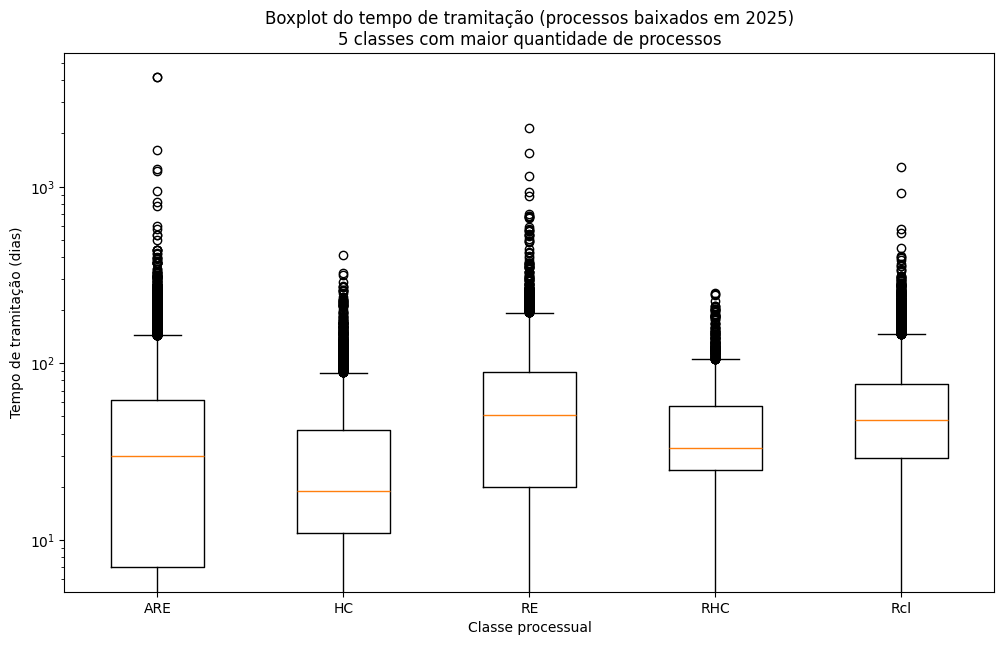

In [0]:

import matplotlib.pyplot as plt

# 1) Buscar dados (tempo_tramitacao) apenas das 5 classes mais frequentes, decididos em 2025
query = """
WITH top_classes AS (
    SELECT
        classe,
        COUNT(DISTINCT processo) AS qtde_processos
    FROM gold.vw_distribuicoes2025_decisoes
    WHERE tempo_tramitacao IS NOT NULL
      AND YEAR(data_baixa) = 2025
    GROUP BY classe
    ORDER BY qtde_processos DESC
    LIMIT 5
)
SELECT
    d.classe,
    d.tempo_tramitacao
FROM gold.vw_distribuicoes2025_decisoes d
JOIN top_classes t
  ON d.classe = t.classe
WHERE d.tempo_tramitacao IS NOT NULL
  AND YEAR(d.data_baixa) = 2025
"""

pdf = spark.sql(query).toPandas()

# 2) Ordenar as classes pelo volume (opcional, mas ajuda na leitura)
#    (se quiser, pode pegar a ordem do top_classes por outra query)
classes = sorted(pdf["classe"].unique())

# 3) Preparar os dados por classe
data_por_classe = [pdf.loc[pdf["classe"] == c, "tempo_tramitacao"].values for c in classes]

# 4) Plotar boxplot
plt.figure(figsize=(12, 7))
plt.boxplot(data_por_classe, labels=classes, showfliers=True)

plt.yscale("log")

plt.xlabel("Classe processual")
plt.ylabel("Tempo de tramitação (dias)")
plt.title("Boxplot do tempo de tramitação (processos baixados em 2025)\n5 classes com maior quantidade de processos")

plt.show()


**Tempo de análise para o Relator proferir decisão final**

Avaliando quanto tempo os Ministros do STF demoram para proferir uma 'Decisão Final', observa-se que a Presidência tem uma média bem baixa em relação aos demais Ministros, o que faz sentido com as atribuições dela, para fazer uma espécie de triagem de processos com poucas chances de admissibilidade.

Além disso, a média de tempo de análise do Ministro Relator varia bastante entre 20 e 60 dias para proferimento de 'Decisão Final'. 

Tendo em vista que os Ministros mais antigos na Corte possuem, em geral, tempo médio de análise menor (< 40 dias), uma possível explicação pode ser a maior experiência na organização dos gabinetes e a existência de menor volume de processos com grau de complexidade maior, por terem sido julgados em anos anteriores. 

In [0]:
%sql
WITH base AS (
    SELECT DISTINCT
        processo,
        classe,
        relator_atual_primeira AS relator,
        tempo_tramitacao,
        tempo_analise_relator,
        tipo_decisao_primeira 
    FROM gold.vw_distribuicoes2025_decisoes
    WHERE tempo_analise_relator IS NOT NULL
    AND tipo_decisao_primeira = "Decisão Final"
   
),
top_classes AS (
    SELECT
        classe
    FROM base
    GROUP BY classe
    ORDER BY COUNT(*) DESC
    LIMIT 5
)
SELECT
    b.relator,
    ROUND(AVG(b.tempo_analise_relator), 0) AS media_dias_ate_decisao,
    COUNT(*)                          AS qtde_processos
FROM base b
JOIN top_classes t
  ON b.classe = t.classe
GROUP BY b.relator
ORDER BY media_dias_ate_decisao, qtde_processos DESC;


relator media_dias_ate_decisao qtde_processos MINISTRO PRESIDENTE 10.0 33138 MIN. DIAS TOFFOLI 22.0 3942 VICE-PRESIDENTE 27.0 297 MIN. CÁRMEN LÚCIA 33.0 4055 MIN. ALEXANDRE DE MORAES 33.0 3902 MIN. EDSON FACHIN 33.0 2527 MIN. GILMAR MENDES 36.0 3714 MIN. CRISTIANO ZANIN 45.0 4026 MIN. FLÁVIO DINO 45.0 3849 MIN. LUIZ FUX 51.0 3691 MIN. NUNES MARQUES 54.0 3591 MIN. ANDRÉ MENDONÇA 62.0 3752 MIN. LUÍS ROBERTO BARROSO 63.0 544

**Tempo de tramitação para julgamento do recurso interno interposto**

Outra medida de interesse é o tempo para análise de um recurso interno interposto no STF (Embargos de Declaração, Agravo Regimental, Embargos de Divergência, etc.). Avaliando os processos decididos em 2025, observa-se que essa decisão de recursos internos demora por volta de 50 dias na grande maioria dos casos.

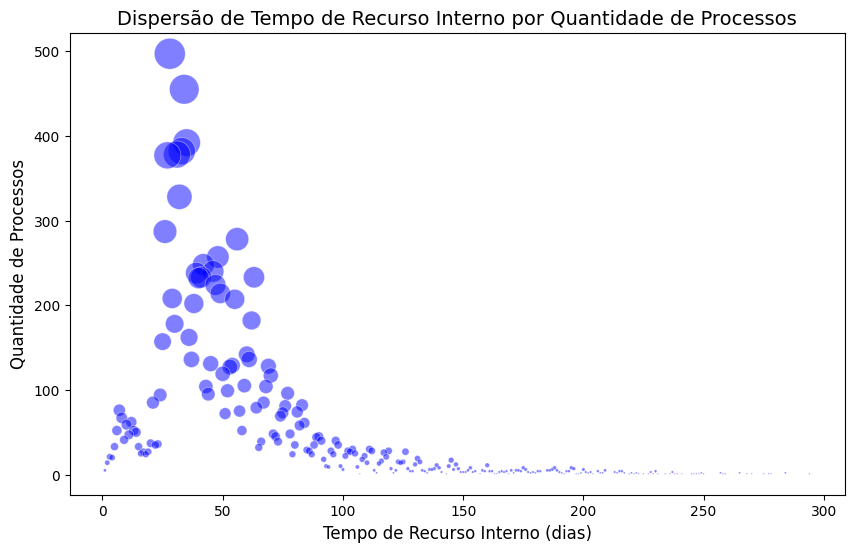

In [0]:
import matplotlib.pyplot as plt

# Consulta SQL no Databricks
query = """
SELECT
    tempo_recurso_interno,
    COUNT(DISTINCT processo) AS qtde_processos
FROM gold.vw_distribuicoes2025_decisoes
WHERE tempo_recurso_interno IS NOT NULL
GROUP BY tempo_recurso_interno
ORDER BY qtde_processos DESC
"""

# Carregar os dados em um DataFrame do Spark
df = spark.sql(query)

# Converter para Pandas para facilitar o gráfico
df_pandas = df.toPandas()

# Dados para o gráfico
x = df_pandas['tempo_recurso_interno']  # Eixo X: Tempo do recurso interno
y = df_pandas['qtde_processos']  # Eixo Y: Quantidade de processos
size = y  # Tamanho das bolhas (quantidade de processos)

# Criando o gráfico de bolhas
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=size, alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Títulos e rótulos
plt.title('Dispersão de Tempo de Recurso Interno por Quantidade de Processos', fontsize=14)
plt.xlabel('Tempo de Recurso Interno (dias)', fontsize=12)
plt.ylabel('Quantidade de Processos', fontsize=12)

# Exibir o gráfico
plt.show()

#### 5.3 Identificando as principais variáveis para julgados favoráveis e desfavoráveis

**Total de processos classificados pelo desfecho**

Analisando a classificação feita da conclusão dos julgamentos realizados pelos Ministros e Órgãos do STF, percebe-se que mais 70% dos processos não tem suas pretensões acolhidas, além de que quase 17% dos processos foram remetidos indevidamente ao STF, considerando a sistemática de julgamento de Repercussão Geral.

Esse não é um dado que impressiona quem atua com Tribunais Superiores, mas que evidencia que a maior parte do trabalho realizado pela Suprema Corte não altera a situação das partes que a ele recorrem, demonstrando uma ineficiência do sistema judicial.



In [0]:
%sql

WITH base AS (
    SELECT
        resultado_final_classificado,
        COUNT(DISTINCT processo) AS qtde_processos
    FROM gold.vw_resultado_decisao_final_2025
    GROUP BY resultado_final_classificado
)
SELECT
    resultado_final_classificado,
    qtde_processos,
    ROUND(
        100.0 * qtde_processos / SUM(qtde_processos) OVER (),
        2
    ) AS percentual_total_desfecho
FROM base
ORDER BY qtde_processos DESC;



resultado_final_classificado qtde_processos percentual_total_desfecho desfavoravel 59300 70.63 devolucao 14244 16.97 favoravel 8704 10.37 sigiloso 908 1.08 homologacao 800 0.95

**Processos classificados pelo desfecho e por órgão julgador do STF**

A presente consulta mantém a congruência com os índices de não provimento, destacando-se que as decisões proferidas nos órgãos colegiados raramento são favoráveis aos seus autores. É relevante destacar que os órgãos colegiados, geralmente, decidem em casos de recurso interno, o que significa que na imensa maioria das vezes (> ~90%) as decisões monocráticas são mantidas.



In [0]:
%sql
WITH base AS (
    SELECT
        orgao_julgador,
        resultado_final_classificado,
        COUNT(DISTINCT processo) AS qtde
    FROM gold.vw_resultado_decisao_final_2025
    GROUP BY orgao_julgador, resultado_final_classificado
)
SELECT
    orgao_julgador,
    resultado_final_classificado,
    qtde,
    ROUND(
        100.0 * qtde / SUM(qtde) OVER (PARTITION BY orgao_julgador),
        2
    ) AS percentual_no_orgao
FROM base
ORDER BY orgao_julgador, qtde DESC;




orgao_julgador resultado_final_classificado qtde percentual_no_orgao 1ª TURMA desfavoravel 5990 95.05 1ª TURMA favoravel 311 4.93 1ª TURMA homologacao 1 0.02 2ª TURMA desfavoravel 5949 93.05 2ª TURMA favoravel 442 6.91 2ª TURMA devolucao 2 0.03 MONOCRÁTICA desfavoravel 43224 64.89 MONOCRÁTICA devolucao 14235 21.37 MONOCRÁTICA favoravel 7450 11.18 MONOCRÁTICA sigiloso 908 1.36 MONOCRÁTICA homologacao 799 1.20 TRIBUNAL PLENO desfavoravel 4137 89.06 TRIBUNAL PLENO favoravel 501 10.79 TRIBUNAL PLENO devolucao 7 0.15

Processos classificados pelo desfecho e por Tribunal de origem

In [0]:
%sql
WITH base AS (
    SELECT
        tribunal_origem,
        resultado_final_classificado,
        COUNT(DISTINCT processo) AS qtde_processos
    FROM gold.vw_resultado_decisao_final_2025
    GROUP BY tribunal_origem, resultado_final_classificado
)
SELECT
    tribunal_origem,
    resultado_final_classificado,
    qtde_processos,
    SUM(qtde_processos) OVER (PARTITION BY tribunal_origem) AS total_tribunal,
    ROUND(
        100.0 * qtde_processos / SUM(qtde_processos) OVER (PARTITION BY tribunal_origem),
        2
    ) AS percentual_no_tribunal
FROM base
ORDER BY qtde_processos DESC;





tribunal_origem resultado_final_classificado qtde_processos total_tribunal percentual_no_tribunal SUPREMO TRIBUNAL FEDERAL desfavoravel 20795 28070 74.08 null desfavoravel 8217 10602 77.50 SUPREMO TRIBUNAL FEDERAL favoravel 6315 28070 22.50 TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO desfavoravel 6178 7997 77.25 TRIBUNAL REGIONAL FEDERAL DA 4ª REGIÃO desfavoravel 1869 3393 55.08 null favoravel 1813 10602 17.10 TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO devolucao 1638 7997 20.48 TRIBUNAL DE JUSTIÇA DO ESTADO DE MINAS GERAIS desfavoravel 1569 2055 76.35 TRIBUNAL DE JUSTIÇA DO ESTADO DE SANTA CATARINA desfavoravel 1392 1631 85.35 SUPERIOR TRIBUNAL DE JUSTIÇA desfavoravel 1385 1555 89.07 TRIBUNAL REGIONAL FEDERAL DA 3ª REGIÃO desfavoravel 1379 1957 70.46 TRIBUNAL REGIONAL FEDERAL DA 4ª REGIÃO devolucao 1371 3393 40.41 TRIBUNAL DE JUSTIÇA DO ESTADO DO RIO GRANDE DO SUL desfavoravel 1331 1740 76.49 TRIBUNAL DE JUSTIÇA DO ESTADO DO RIO DE JANEIRO desfavoravel 1282 1689 75.90 TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E TERRITÓRIOS desfavoravel 981 1366 71.82 TRIBUNAL DE JUSTIÇA DO ESTADO DE GOIÁS desfavoravel 920 1211 75.97 TRIBUNAL DE JUSTIÇA DO ESTADO DO PARANÁ desfavoravel 833 1061 78.51 SUPREMO TRIBUNAL FEDERAL sigiloso 704 28070 2.51 TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO desfavoravel 684 1053 64.96 TRIBUNAL REGIONAL FEDERAL DA 1ª REGIÃO devolucao 649 1132 57.33 TRIBUNAL DE JUSTIÇA DO ESTADO DA BAHIA desfavoravel 608 826 73.61 TRIBUNAL REGIONAL FEDERAL DA 2ª REGIÃO desfavoravel 606 855 70.88 TRIBUNAL SUPERIOR DO TRABALHO desfavoravel 519 618 83.98 TRIBUNAL REGIONAL FEDERAL DA 3ª REGIÃO devolucao 509 1957 26.01 TRIBUNAL REGIONAL FEDERAL DA 1ª REGIÃO desfavoravel 445 1132 39.31 TRIBUNAL DE JUSTIÇA DO ESTADO DE MINAS GERAIS devolucao 444 2055 21.61 TRIBUNAL DE JUSTIÇA DO ESTADO DO CEARÁ desfavoravel 438 582 75.26 TRIBUNAL DE JUSTIÇA DO ESTADO DE PERNAMBUCO desfavoravel 402 715 56.22 TRIBUNAL DE JUSTIÇA DO ESTADO DO MATO GROSSO DO SUL desfavoravel 388 485 80.00 TRIBUNAL DE JUSTIÇA DO ESTADO DO RIO DE JANEIRO devolucao 371 1689 21.97 TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO devolucao 339 1053 32.19 TRIBUNAL DE JUSTIÇA DO ESTADO DO RIO GRANDE DO SUL devolucao 336 1740 19.31 TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E TERRITÓRIOS devolucao 333 1366 24.38 TRIBUNAL DE JUSTIÇA DO ESTADO DE PERNAMBUCO devolucao 304 715 42.52 TRIBUNAL DE JUSTIÇA DO ESTADO DO ESPÍRITO SANTO desfavoravel 302 374 80.75 TRIBUNAL DE JUSTIÇA DO ESTADO DE SERGIPE desfavoravel 294 576 51.04 TRIBUNAL DE JUSTIÇA DO ESTADO DE ALAGOAS desfavoravel 283 435 65.06 TRIBUNAL DE JUSTIÇA DO ESTADO DE SERGIPE devolucao 278 576 48.26 TRIBUNAL DE JUSTIÇA DO ESTADO DE GOIÁS devolucao 270 1211 22.30 SUPREMO TRIBUNAL FEDERAL homologacao 256 28070 0.91 TRIBUNAL DE JUSTIÇA DO ESTADO DA PARAÍBA desfavoravel 247 374 66.04 null devolucao 242 10602 2.28 TRIBUNAL DE JUSTIÇA DO ESTADO DO MATO GROSSO desfavoravel 240 294 81.63 TJAL - TURMA RECURSAL UNIFICADA DE MACEIÓ devolucao 227 249 91.16 TRIBUNAL DE JUSTIÇA DO ESTADO DO MARANHÃO desfavoravel 226 371 60.92 TJSE - 2ª TURMA RECURSAL devolucao 223 298 74.83 TRIBUNAL DE JUSTIÇA DO ESTADO DE SANTA CATARINA devolucao 220 1631 13.49 TRIBUNAL REGIONAL FEDERAL DA 2ª REGIÃO devolucao 211 855 24.68 TRIBUNAL DE JUSTIÇA DO ESTADO DO PARANÁ devolucao 209 1061 19.70 TRIBUNAL DE JUSTIÇA DO ESTADO DA BAHIA devolucao 204 826 24.70 TJCE - 3ª TURMA RECURSAL desfavoravel 201 375 53.60 TJRS - RS - 2ª TURMA RECURSAL DA FAZENDA PÚBLICA devolucao 194 264 73.48 null homologacao 194 10602 1.83 TRIBUNAL DE JUSTIÇA DO ESTADO DO PIAUÍ desfavoravel 194 274 70.80 TRIBUNAL DE JUSTIÇA DO ESTADO DO TOCANTINS devolucao 191 360 53.06 TRIBUNAL DE JUSTIÇA DO ESTADO DO PARÁ desfavoravel 177 262 67.56 TJCE - 3ª TURMA RECURSAL devolucao 172 375 45.87 TJRN - 3ª TURMA RECURSAL - CAPITAL devolucao 171 257 66.54 TRIBUNAL DE JUSTIÇA DO ESTADO DO TOCANTINS desfavoravel 169 360 46.94 TJSE - 1ª TURMA RECURSAL devolucao 163 228 71.49 TJSP - COLÉGIO RECURSAL DOS JUIZADOS ESPECIAIS DO ESTADO DE SÃ

In [0]:
%sql
WITH proc_dec AS (
  SELECT DISTINCT processo
  FROM gold.vw_resultado_decisao_final_2025
),
proc_dist AS (
  SELECT DISTINCT processo
  FROM silver.distribuicoes2025stf
)
SELECT COUNT(*) AS processos_sem_match_na_distribuicao
FROM proc_dec d
LEFT ANTI JOIN proc_dist s
ON d.processo = s.processo;


processos_sem_match_na_distribuicao 10602

In [0]:
%sql

SELECT
        procedencia,
        COUNT(DISTINCT processo) AS qtde_processos
    FROM gold.vw_resultado_decisao_final_2025
    WHERE tribunal_origem IS NULL
    GROUP BY procedencia;


procedencia qtde_processos null 10602

Processos classificados pelo desfecho e por ramo do Direito


In [0]:
%sql

WITH base AS (
  SELECT
    ramo_direito,
    resultado_final_classificado,
    COUNT(DISTINCT processo) AS qtde
FROM gold.vw_resultado_decisao_final_2025
GROUP BY ramo_direito, resultado_final_classificado
)
SELECT
    ramo_direito,
    resultado_final_classificado,
    qtde,
    SUM(qtde) OVER (PARTITION BY ramo_direito) AS total_ramo,
    ROUND(
        100.0 * qtde / SUM(qtde) OVER (PARTITION BY ramo_direito),
        2
    ) AS percentual_no_tribunal
FROM base
ORDER BY ramo_direito, qtde DESC;


ramo_direito resultado_final_classificado qtde total_ramo percentual_no_tribunal null favoravel 2973 5993 49.61 null desfavoravel 2615 5993 43.63 null homologacao 197 5993 3.29 null sigiloso 148 5993 2.47 null devolucao 60 5993 1.00 DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO desfavoravel 14248 17529 81.28 DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO favoravel 3038 17529 17.33 DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO homologacao 145 17529 0.83 DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO sigiloso 58 17529 0.33 DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO devolucao 40 17529 0.23 DIREITO AMBIENTAL desfavoravel 182 253 71.94 DIREITO AMBIENTAL favoravel 69 253 27.27 DIREITO AMBIENTAL devolucao 1 253 0.40 DIREITO AMBIENTAL homologacao 1 253 0.40 DIREITO ASSISTENCIAL desfavoravel 88 92 95.65 DIREITO ASSISTENCIAL devolucao 2 92 2.17 DIREITO ASSISTENCIAL favoravel 2 92 2.17 DIREITO CIVIL desfavoravel 3394 3721 91.21 DIREITO CIVIL favoravel 287 3721 7.71 DIREITO CIVIL homologacao 20 3721 0.54 DIREITO CIVIL sigiloso 18 3721 0.48 DIREITO CIVIL devolucao 2 3721 0.05 DIREITO DA CRIANÇA E DO ADOLESCENTE desfavoravel 67 98 68.37 DIREITO DA CRIANÇA E DO ADOLESCENTE favoravel 27 98 27.55 DIREITO DA CRIANÇA E DO ADOLESCENTE sigiloso 4 98 4.08 DIREITO DA SAÚDE desfavoravel 983 1715 57.32 DIREITO DA SAÚDE favoravel 642 1715 37.43 DIREITO DA SAÚDE sigiloso 77 1715 4.49 DIREITO DA SAÚDE homologacao 13 1715 0.76 DIREITO DO CONSUMIDOR desfavoravel 957 1029 93.00 DIREITO DO CONSUMIDOR favoravel 71 1029 6.90 DIREITO DO CONSUMIDOR homologacao 1 1029 0.10 DIREITO DO TRABALHO favoravel 2549 4740 53.78 DIREITO DO TRABALHO desfavoravel 2117 4740 44.66 DIREITO DO TRABALHO homologacao 39 4740 0.82 DIREITO DO TRABALHO sigiloso 31 4740 0.65 DIREITO DO TRABALHO devolucao 4 4740 0.08 DIREITO ELEITORAL desfavoravel 53 90 58.89 DIREITO ELEITORAL favoravel 32 90 35.56 DIREITO ELEITORAL sigiloso 3 90 3.33 DIREITO ELEITORAL homologacao 2 90 2.22 DIREITO ELEITORAL E PROCESSO ELEITORAL DO STF desfavoravel 7 12 58.33 DIREITO ELEITORAL E PROCESSO ELEITORAL DO STF favoravel 4 12 33.33 DIREITO ELEITORAL E PROCESSO ELEITORAL DO STF sigiloso 1 12 8.33 DIREITO INTERNACIONAL desfavoravel 36 75 48.00 DIREITO INTERNACIONAL favoravel 20 75 26.67 DIREITO INTERNACIONAL sigiloso 18 75 24.00 DIREITO INTERNACIONAL homologacao 1 75 1.33 DIREITO MARÍTIMO desfavoravel 1 1 100.00 DIREITO PENAL desfavoravel 6585 7716 85.34 DIREITO PENAL favoravel 965 7716 12.51 DIREITO PENAL sigiloso 127 7716 1.65 DIREITO PENAL homologacao 35 7716 0.45 DIREITO PENAL devolucao 4 7716 0.05 DIREITO PENAL MILITAR desfavoravel 83 113 73.45 DIREITO PENAL MILITAR favoravel 30 113 26.55 DIREITO PREVIDENCIÁRIO desfavoravel 2634 3326 79.19 DIREITO PREVIDENCIÁRIO favoravel 667 3326 20.05 DIREITO PREVIDENCIÁRIO homologacao 22 3326 0.66 DIREITO PREVIDENCIÁRIO sigiloso 3 3326 0.09 DIREITO PROCESSUAL CIVIL E DO TRABALHO desfavoravel 4278 5954 71.85 DIREITO PROCESSUAL CIVIL E DO TRABALHO favoravel 1593 5954 26.76 DIREITO PROCESSUAL CIVIL E DO TRABALHO homologacao 45 5954 0.76 DIREITO PROCESSUAL CIVIL E DO TRABALHO sigiloso 29 5954 0.49 DIREITO PROCESSUAL CIVIL E DO TRABALHO devolucao 9 5954 0.15 DIREITO PROCESSUAL PENAL desfavoravel 15731 18207 86.40 DIREITO PROCESSUAL PENAL favoravel 1819 18207 9.99 DIREITO PROCESSUAL PENAL sigiloso 526 18207 2.89 DIREITO PROCESSUAL PENAL homologacao 125 18207 0.69 DIREITO PROCESSUAL PENAL devolucao 6 18207 0.03 DIREITO PROCESSUAL PENAL MILITAR desfavoravel 62 91 68.13 DIREITO PROCESSUAL PENAL MILITAR favoravel 27 91 29.67 DIREITO PROCESSUAL PENAL MILITAR sigiloso 2 91 2.20 DIREITO TRIBUTÁRIO desfavoravel 6523 7771 83.94 DIREITO TRIBUTÁRIO favoravel 1075 7771 13.83 DIREITO TRIBUTÁRIO homologacao 154 7771 1.98 DIREITO TRIBUTÁRIO devolucao 18 7771 0.23 DIREITO TRIBUTÁRIO sigiloso 1 7771 0.01 DIREITO À EDUCAÇÃO desfavoravel 612 662 92.45 DIREITO À EDUCAÇÃO favoravel 41 662 6.19 DIREITO À EDUCAÇÃO homologacao 8 66

### 5.3 Resposta das perguntas iniciais




1. Quais e quantos processos foram autuados no ano de 2025?



2. É possível identificar as pessoas e entidades com maior quantidade de recursos e o polo processual que elas ocupam?



3. Qual o resultado dos julgamentos desses processos?



4. Existe alguma tendência nos julgamentos (favoráveis ou desfavoráveis) por tema, origem ou pessoa/entidade?



5. Qual tempo médio de tramitação dos recursos por origem e por Ministro Relator dos processos?


#### 6. Auto avaliação 

In [0]:
##